In [1]:
!pip install tensorflow-text
!pip install tensorflow-hub
!pip install pandas
!pip install scikit-learn
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import pandas as pd


In [2]:
import pandas as pd
import math as m
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

pd.read_csv('safedownsampled.csv')

,Unnamed: 0,body,class
0,10195,use Perl Daily Headline MailerDynDNS.org Offer...,Safe Email
1,8911,conference on catalan studies ( linguistic sec...,Safe Email
2,3284,re : transwestern weekly report lindy - we rec...,Safe Email
3,4432,"sum : dets and number about a month ago , i po...",Safe Email
4,10211,Mike Masnick wrote:\n>Why is it that people do...,Safe Email
...,...,...,...
3182,708,"high frequency market data analysis stinson , ...",Safe Email
3183,1154,"fw : mark boland - cv vince : tony vasut , ano...",Safe Email
3184,2464,re : meter 0980438 - acock production ? ? ? ? ...,Safe Email
3185,2804,[Barry]\n> Here's an interesting thing to test...,Safe Email


### **After Down sampling the "big safe emails" to 3k safe email to be balanced with phishing**

In [3]:

import pandas as pd

df_ph = pd.read_csv('body_and_class.csv')
df_safe = pd.read_csv('safe_downsampled.csv')

df_ph = df_ph.drop('Unnamed: 0', axis=1, errors='ignore')
df_ph= df_ph.drop_duplicates()

df_safe = df_safe.drop('Unnamed: 0', axis=1, errors='ignore')
df_safe = df_safe.drop_duplicates()

print(df_ph, df_safe)

df_balanced = pd.concat([df_safe,df_ph])


print(df_balanced.shape)
df_balanced = df_balanced.sample(frac=1, random_state=42)

df_balanced.groupby('class').describe()

print("Safe",len(df_safe))
print("Phishing",len(df_ph))

                                                   body     class
0     eBay Suspension\neBay Suspension\nNeed Help?\n...  phishing
1     Dear LaSalle Member,\nAs part of our continuin...  phishing
2       But I don't Pokemon in 1878 in 1874 Shall we...  phishing
3     Dear eBay member,\nDear eBay user,\nDuring our...  phishing
4     Dear valued customer\nNeed Help?\nWe regret to...  phishing
...                                                 ...       ...
3182  Dear NAFCU member,\nAs part of our security me...  phishing
3183  lay flog, me zing sell, net sick burr macepay ...  phishing
3184  eBay\nBilling \n          confirmation center\...  phishing
3185  Dear Valued Customer\nWe are committed to prot...  phishing
3186  National Credit Union Administration  Notifica...  phishing

[3187 rows x 2 columns]                                                    body       class
0     use Perl Daily Headline MailerDynDNS.org Offer...  Safe Email
1     conference on catalan studies ( linguisti

In [4]:

df_ph = df_balanced[df_balanced['class'] == 'phishing']
df_safe = df_balanced[df_balanced['class'] == 'Safe Email']
from sklearn.utils import resample
df_ph_downsampled = resample(df_ph, replace=False, n_samples=1300, random_state=42)
df_safe_downsampled = resample(df_safe, replace=False, n_samples=2000, random_state=42)

df_downsampled = pd.concat([df_ph_downsampled, df_safe_downsampled])

df_downsampled = df_downsampled.sample(frac=1, random_state=42)
print(len(df_downsampled))

3300


### **50% Phishing 50% Safe emails:**

### Map:  Phishing => 1 . Safe => 0




In [5]:

df_downsampled['phishing']=df_downsampled['class'].apply(lambda x: 1 if x =='phishing' else 0)
df_downsampled.sample(5)


,body,class,phishing
509,"\nTo ensure delivery to your inbox, please ad...",phishing,1
1630,\r\n\r\nFrom: ÐÐ°ÐºÐµÐµÐ² Ð¡ÐµÑÐ³ÐµÐ¹ ÐÑÑ...,phishing,1
2633,Security Center Advisory!\nWe recently noticed...,phishing,1
76,re : cornhusker i meant to copy you guys on th...,Safe Email,0
947,A new payee has been added to your Bill Pay se...,phishing,1


### **Split it into training and test data set**

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_downsampled['body'],df_downsampled['phishing'],
                                                    stratify=df_downsampled['phishing'],random_state=42,test_size=0.3)

X_train.head(4)

1648    http://www.hughes-family.org/bugzilla/show_bug...
1937    Well, it looks like Sun are going ahead with\n...
2040    associate and analyst program contacts associa...
27      Update of /cvsroot/spamassassin/spamassassin/m...
Name: body, dtype: object


### **Using BERT model and get embeding vectors**


In [7]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [8]:
text_input= tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text= bert_preprocess(text_input)
outputs= bert_encoder(preprocessed_text)

dropout_layer = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
dense_layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(dropout_layer)


model = tf.keras.Model(inputs=[text_input], outputs = [dense_layer])
print( model.summary() )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [9]:
len(X_train)

2310

In [10]:

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)



# **Model Train**

In [12]:
!pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

X_train_preprocessed = np.array([str(sentence) for sentence in X_train])
X_test_preprocessed = np.array([str(sentence) for sentence in X_test])
y_train = np.array(y_train)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_preprocessed, y_train, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_split, y_train_split))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_split, y_val_split))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_preprocessed, y_test))

batch_size = 32

train_dataset = train_dataset.shuffle(buffer_size=len(X_train_split)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

class_weights = {0: 1, 1: 2}

history = model.fit(X_train_split, y_train_split, epochs=10, validation_data=(X_val_split, y_val_split), class_weight=class_weights, callbacks=[early_stopping, checkpoint])

  Using cached matplotlib-3.8.3-cp39-cp39-win_amd64.whl.metadata (5.9 kB)
  Using cached contourpy-1.2.0-cp39-cp39-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/162.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/162.6 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.6 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.6 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.6 kB ? eta -:--:--
     ------ ------------------------------ 30.7/162.6 kB 163.8 kB/s eta 0:00:01
     ------ ------------------------------ 30.7/162.6 kB 163.8 kB/s eta 0:00:01
     ------ ------------------------------ 30.7/162.6 kB 163.8 kB/s eta 0:00:01
     ------ ------------------------------ 30.7/162.6 kB 163.8 kB/s eta 0:00:01
     ------ ------------------------------ 30.7/162.6 kB 163.8 kB/s eta 0:00:01
     ------ ---------

# **Model Traning Evaluation**

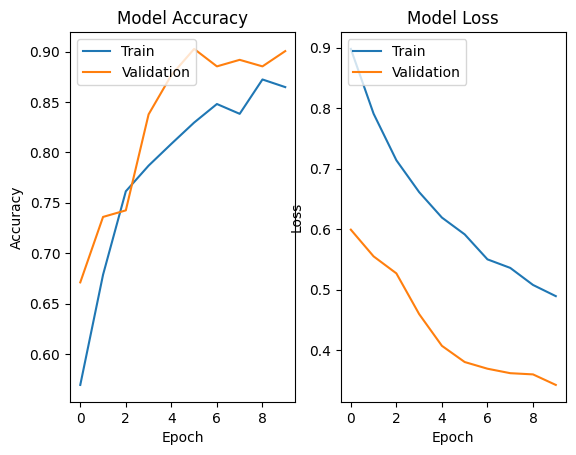

In [13]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


31/31 [==============================] - 13s 355ms/step


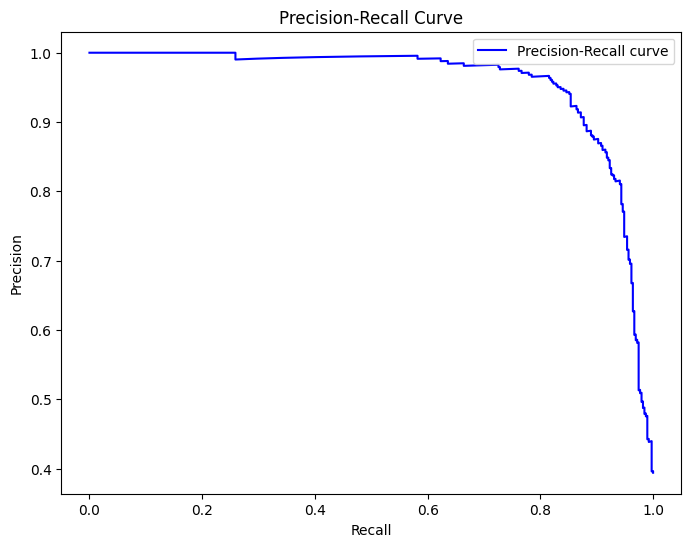

In [14]:

results = model.evaluate(test_dataset)

y_pred = model.predict(test_dataset).ravel()

precision, recall, _ = precision_recall_curve(y_test, y_pred)


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()



In [15]:
auc_pr = auc(recall, precision)
print(f'AUC-PR: {auc_pr}')

AUC-PR: 0.9565150966665357


In [16]:
accuracy = results[model.metrics_names.index('accuracy')]
precision = results[model.metrics_names.index('precision')]
recall = results[model.metrics_names.index('recall')]

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.9131312966346741
Precision: 0.8877550959587097
Recall: 0.892307698726654


# **Model Saving**

In [ ]:

model_path = 'my_model.h5'

model.save(model_path)

print("Model saved successfully at:", model_path)



Model saved successfully at: my_model.h5


# **Modle Loading**

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from sklearn.metrics import classification_report

model_path = 'best_model.h5'
custom_objects = {'KerasLayer': hub.KerasLayer}
loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

results = loaded_model.evaluate(X_test_preprocessed, y_test)

accuracy = results[loaded_model.metrics_names.index('accuracy')]
precision = results[loaded_model.metrics_names.index('precision')]
recall = results[loaded_model.metrics_names.index('recall')]

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')


31/31 [==============================] - 12s 350ms/step - loss: 0.3107 - accuracy: 0.9424 - precision: 0.6571 - recall: 0.7667
Accuracy: 0.9424242377281189
Precision: 0.6571428775787354
Recall: 0.7666666507720947


In [22]:
loaded_model = tf.keras.models.load_model('best_model.h5', custom_objects={'KerasLayer': hub.KerasLayer})

new_text = """begin forwarded text To: rah@shipwright.com From: hacker@vudu.net Date: Thu, 03 Oct 2002 06:01:38 -0700 (PDT) Subject: Re: The 3rd Annual Consult Hyperion Digital Identity ForumThe guy messed up his own URL. It should be http://www.digitalidforum.com which redirects to http://www.consult.hyperion.co.uk/digid3.html "R. A. Hettinga" wrote: > > Dear All, > > See www.digitalidentityforum.com for more details. Speakers include > Microsoft and Liberty Alliance, UK central and local government, > law > enforcement, financial services (Egg and RBS/NatWest), EC Research > Centre, a > psychologist and others. Look forward to seeing you there. > > Regards, > Dave Birch. > > -- > -- David Birch, Director, Consult Hyperion > -- > -- tel +44 (0)1483 301793, fax +44 (0)1483 561657 > -- mail dave@chyp.com, web http://www.chyp.com > -- > -- See you at the 2nd Annual Digital Transactions Forum in > Singapore > -- October 16th/17th 2002, see > http://www.digitaltransactionsforum.com/ > > --- end forwarded text > > > -- > ----------------- > R. A. Hettinga <mailto: rah@ibuc.com> > The Internet Bearer Underwriting Corporation <http://www.ibuc.com/>; > 44 Farquhar Street, Boston, MA 02131 USA > "... however it may deserve respect for its usefulness and > antiquity, > [predicting the end of the world] has not been found agreeable to > experience." -- Edward Gibbon, 'Decline and Fall of the Roman > Empire' > > For help on using this list (especially unsubscribing), send a > message to > "dcsb-request@reservoir.com" with one line of text: "help".--- end forwarded text -- ----------------- R. A. Hettinga The Internet Bearer Underwriting Corporation 44 Farquhar Street, Boston, MA 02131 USA "... however it may deserve respect for its usefulness and antiquity, [predicting the end of the world] has not been found agreeable to experience." -- Edward Gibbon, 'Decline and Fall of the Roman Empire'
"""

new_text_preprocessed = np.array([str(new_text)])

predictions = "Phishing" if loaded_model.predict(new_text_preprocessed) > 0.5 else "Safe"

print(predictions)

1/1 [==============================] - 1s 864ms/step
Safe
